# Predicting Human Motion Time Series

## Introduction

Given [the dataset](http://ps.ewi.utwente.nl/Datasets.php), we first need to make some assumptions on what the dataset is and how do we want to handle it. This is clearly a time series problem, and hidden markov model (HMM) based classifiers have been shown to do well in such problems [[1],[2],[3]].

**TODO:** Finish the description

To be honest, I have heard of HMMs before, but have never implemented them myself, so don't laugh too hard if I do some silly mistakes -- I just finished reading some papers about it :)

[1]: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3244008/
[2]: http://jmlr.org/proceedings/papers/v37/goernitz15.html
[3]: http://icml.cc/2012/papers/426.pdf

### Preliminaries

In [1]:
import pandas as pd
%pylab --no-import-all
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

sensors = ('Arm', 'Belt', 'Pocket', 'Wrist')
columns = ('Time_Stamp','Ax','Ay','Az','Gx','Gy','Gz','Mx','My','Mz','Activity_Label')
classes = ('Downstairs', 'Running', 'Sitting', 'Standing', 'Upstairs', 'Walking')

time_columns = ['Time_Stamp']
x_columns = ['Ax','Ay','Az','Gx','Gy','Gz','Mx','My','Mz']
y_columns = ['Activity_Label']

data = {}

## CSVs are faster than XLSX
## Do NOT use Excel to save CSVs, you will lose precision
## use the script attached 
for sensor in sensors:
  print 'Loading ' + sensor + '...'
  fname = './data/' + sensor + '.csv'
  data[sensor] = pd.read_csv(fname, header = 0)
  data[sensor]['Activity_Label'] = data[sensor]['Activity_Label'].replace(classes, range(len(classes)))
  
data_extract = {}
for sensor in sensors:
  data_extract[sensor] = {}
  data_extract[sensor]['X'] = data[sensor][x_columns]
  data_extract[sensor]['time'] = data[sensor][time_columns]
  data_extract[sensor]['y'] = data[sensor][y_columns]

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
Loading Arm...
Loading Belt...
Loading Pocket...
Loading Wrist...


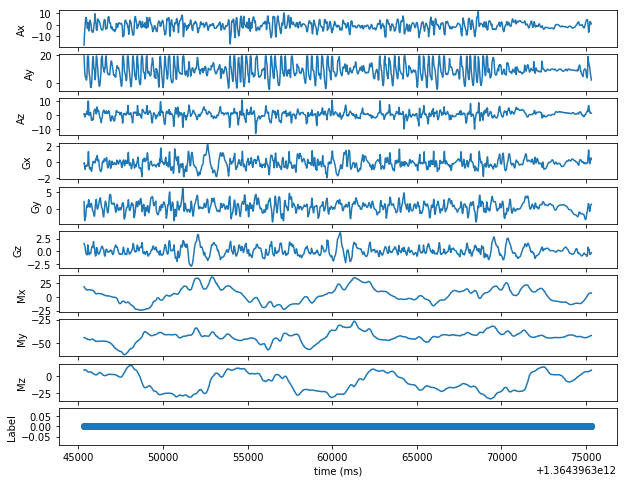

In [2]:
start = 0
end = 1500
sens = 0
fig, ax = plt.subplots(len(x_columns)+1)
for idx in xrange(len(x_columns)):
  ax[idx].plot(
    data[sensors[sens]][time_columns].values[start:end],
    data[sensors[sens]][x_columns[idx]].values[start:end]
  )
  ax[idx].set_ylabel(x_columns[idx])
ax[-1].scatter(
  data[sensors[sens]][time_columns].values[start:end],
  data[sensors[sens]][y_columns].values[start:end]
)
ax[-1].set_ylabel('Label')
ax[-1].set_xlabel('time (ms)')

---

## Warm Up -- Random Forest as a Silver Bullet

As a warm up let us try using a naive approach of using every input as an independent point. Note, some models might be already saved under the `models` folder.

Random Forest algorithms might be very useful for areas where high accuracy is required, but there is very limited budget in terms of time, feature acquisition cost, energy dissipation, computational power, etc... There are some prior works that focus exactly on that: [[4], [5]], also emailed paper.

[4]: https://papers.nips.cc/paper/6250-pruning-random-forests-for-prediction-on-a-budget.pdf
[5]: http://people.bu.edu/joshi/files/Takhirov-ISLPED-2016.pdf

**TODO:** If time permits provide description of FoG architecture

The results below show how a Random Forest Classifier would behave while ignoring the temporal dependency.

In [3]:
import pickle
import os

with open('./models/rf_all.results', 'r') as f:
  results = pickle.load(f)

res_type = ['Train', 'CV', 'Test']
print "Accuracy scores"
print '"None" corresponds to no limitations on decision tree depth'
print "Columns: Maximum RF Depth"
print "Rows: Number of decision trees"
for idx in xrange(len(results)):
  print ''
  print res_type[idx], "Data"
  print results[idx]
  

Accuracy scores
"None" corresponds to no limitations on decision tree depth
Columns: Maximum RF Depth
Rows: Number of decision trees

Train Data
        5.0       7.0       10.0     NaN  
15  0.624726  0.733289  0.815160  0.999574
20  0.615342  0.726272  0.825710  0.999803
30  0.646150  0.729968  0.825453  0.999922
50  0.648992  0.730606  0.827479  0.999989

CV Data
        5.0       7.0       10.0     NaN  
15  0.624096  0.731697  0.808976  0.953772
20  0.615685  0.724217  0.819512  0.956519
30  0.645402  0.729586  0.818581  0.958629
50  0.648738  0.729136  0.820335  0.960569

Test Data
        5.0       7.0       10.0     NaN  
15  0.626320  0.733347  0.809905  0.955161
20  0.616249  0.726325  0.820217  0.957566
30  0.647432  0.729538  0.819627  0.960142
50  0.650101  0.730826  0.822157  0.961477


As we can see above, it is more useful to have deeper trees, rather than large number of trees. We could go through more simulations to find better hyperparameters, but that is besides the point :)  I will not go into furhter discussion of Random Forests, as I am assuming the purpose of this excercise is to evaluate my ability to transfer theoretical work to the real world implementation, and it would unfair for me to provide the codes that I have written in the past

---

## Recurrent Neural Networks (RNN) and Long-Short Term Memory (LSTM)

I love recurrent NNs -- I am just fascinated by their idea -- I might get discouraged later on though :). On my TODO list, there are still several projects with RNNs. However, I have never (until today) implemented one.

I will be working on the very early versions of the LSTMs described first by [[6]], and with full details in [[7]] (I personally didn't finish the PhD dissertation, only read parts of it). The paper that describes the current algorithm was published by Zaremba in ICML [[8]]. The explanation equations below are the modern interpretations of the works in [[6], [7]], and come from [[9], [10]]. I have also used [[11]] for my own references.

[6]: http://dl.acm.org/citation.cfm?id=1246450
[7]: http://www.felixgers.de/papers/phd.pdf
[8]: https://arxiv.org/pdf/1409.2329.pdf
[8a]: https://arxiv.org/pdf/1406.1078v3.pdf
[9]: https://arxiv.org/pdf/1308.0850.pdf
[10]: http://colah.github.io/posts/2015-08-Understanding-LSTMs/
[11]: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

<!-- [^1]: I can't believe something that was invented ~15 years ago is already considered not modern! :) -->

### Methodology

The blog diagrams for a "normal" LSTM are coming from Chris Olah blog [[10]] (see the block diagram below). So does the notation for the equations.

![LSTM Olah](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

A single cell in the LSTM is defined by the following set of equations

$$
\begin{align}
    \mbox{forget gate: }
    f_t &= \sigma \left( W_f \cdot \left[ h_{t-1}, x_t \right] + b_f\right) \\
    \mbox{input (update) gate: }
    i_t &= \sigma \left( W_i \cdot \left[ h_{t-1}, x_t \right] + b_i\right) \\
    \mbox{new candidate: }
    \tilde C_t &= \mbox{tanh} \left( W_C \cdot \left[ h_{t-1}, x_t \right] + b_C\right) \\
    \mbox{updating the cell state: }
    C_t &= f_t * C_{t-1} + i_t * \tilde C_t \\
    ~\\
    \mbox{Output result gate: }
    o_t &= \sigma \left( W_o \cdot \left[ h_{t-1}, x_t \right] + b_o\right) \\
    \mbox{New hypothesis: }
    h_t &= o_t * \mbox{tanh}\left(C_t\right)
\end{align}
$$

The equations above are fairly easy to read, but for the sake of fairness, let us paraphrase what the paper actually said and what the equations above really mean (in English):

> Once we receive a new input $x_t$, we concatenate it with our prior assumption on the result $h_{t-1}$. We pass this input through several "gates": forget gate decides if some prior decision should be forgotten (or attenuated), update gate adds information about the current input to the internal state (our memory). At the same time the input is also fed into the output gate, in case it has an immediate effect on the result. After we combine the state with the output gate result, we can make a decision while remembering old information.

#### Foreword about my Laziness

Ideally we want to combine the data from all the sensors, and use one of the alignment algorithms (i.e. [DTW](https://en.wikipedia.org/wiki/Dynamic_time_warping)) such that we align the time series acquired from all sensors, and treat the inputs as combined input vector. However, I am a little short on time, given I have to finish my dissertation write up by tomorrow as well, I will use another set of steps:

1. Train several LSTMs -- 1 for every sensor.
2. During evaluation phase run all of LSTMs, and produce candidate results
3. Use majority vote to identify the most likely candidate
    - We might want to give sensors weights, which might be determined using the cross validation set. This might be needed because we don't want all the sensors to be equally important

### Implementation

The codes are located in the [`lstm.py`](lstm.py). The wrapper methods are shamelessly borrowed from [nivwusquorum](https://gist.github.com/nivwusquorum/)

Below is a snippet of a cell. The code itself is very long, you can open it externally from [`lstm_test1.py`](lstm_test1.py)

In [ ]:
# %load './lstm/lstm.py'
#!/usr/bin/env python

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import collections

import tensorflow as tf

from tensorflow.python.ops import variable_scope as vs

from tensorflow.python.ops.math_ops import sigmoid
from tensorflow.python.ops.math_ops import tanh
from tensorflow.python.ops.rnn_cell_impl import _RNNCell as RNNCell
# from tensorflow.contrib.rnn import LSTMStateTuple
from tensorflow.contrib import layers

from tensorflow.contrib.rnn.python.ops.core_rnn_cell_impl import _linear as linear
from tensorflow.python.ops import array_ops

_LSTMStateTuple = collections.namedtuple("LSTMStateTuple", ("c", "h"))
class LSTMStateTuple(_LSTMStateTuple):
  """Tuple used by LSTM Cells for `state_size`, `zero_state`, and output state.

  Stores two elements: `(c, h)`, in that order.
  """
  __slots__ = ()

  @property
  def dtype(self):
    (c, h) = self
    if not c.dtype == h.dtype:
      raise TypeError("Inconsistent internal state: %s vs %s" %
                      (str(c.dtype), str(h.dtype)))
    return c.dtype

class LSTMCellOlah(tf.contrib.rnn.RNNCell):
  """
  See the following:
    - http://arxiv.org/abs/1409.2329
    - http://colah.github.io/posts/2015-08-Understanding-LSTMs/
    - http://karpathy.github.io/2015/05/21/rnn-effectiveness/

  This is a simplified implementation -- it ignores most biases, and it somewhat simplifies the equations shown in the references above.
  """
  def __init__(self, num_units, *args, **kwargs):
    self._num_units = num_units

  @property
  def state_size(self):
    return LSTMStateTuple(self._num_units, self._num_units)

  @property
  def output_size(self):
    return self._num_units

  def __call__(self, inputs, state, scope="LSTM"):
    with tf.variable_scope(scope):
      c, h = state

      concat = linear([inputs, h], 4 * self._num_units, True)
      # i = input_gate, j = new_input, f = forget_gate, o = output_gate
      i, j, f, o = array_ops.split(value=concat, num_or_size_splits=4, axis=1)

      forget_bias = 1.0
      new_c = (c * tf.nn.sigmoid(f + forget_bias)
               + tf.nn.sigmoid(i) * tf.nn.tanh(j))
      new_h =  tf.nn.tanh(new_c) * tf.nn.sigmoid(o)

      return new_h, LSTMStateTuple(new_c, new_h)

  def zero_state(self, batch_size, dtype=tf.float32, learnable=False, scope="LSTM"):
    if learnable:
      c = tf.get_variable("c_init", (1, self._num_units),
              initializer=tf.random_normal_initializer(dtype=dtype))
      h = tf.get_variable("h_init", (1, self._num_units),
              initializer=tf.random_normal_initializer(dtype=dtype))
    else:
      c = tf.zeros((1, self._num_units), dtype=dtype)
      h = tf.zeros((1, self._num_units), dtype=dtype)
    c = tf.tile(c, [batch_size, 1])
    h = tf.tile(h, [batch_size, 1])
    c.set_shape([None, self._num_units])
    h.set_shape([None, self._num_units])
    return (c, h)


Here are the preliminary results **before cross validation is implemented**

```
$> ./lstm_test1.py
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use FMA instructions, but these are available on your machine and could speed up CPU computations.
Iter 1280, Minibatch Loss= 0.432134, Training Accuracy= 0.91406
Iter 2560, Minibatch Loss= 4.235562, Training Accuracy= 0.00000
Iter 3840, Minibatch Loss= 3.661356, Training Accuracy= 0.00000
Iter 5120, Minibatch Loss= 2.457803, Training Accuracy= 0.13281
Iter 6400, Minibatch Loss= 0.385571, Training Accuracy= 1.00000
Iter 7680, Minibatch Loss= 2.319496, Training Accuracy= 0.42188
Iter 8960, Minibatch Loss= 0.956249, Training Accuracy= 0.56250
Iter 10240, Minibatch Loss= 0.188828, Training Accuracy= 0.96875
Iter 11520, Minibatch Loss= 0.368966, Training Accuracy= 0.96875
Iter 12800, Minibatch Loss= 0.852489, Training Accuracy= 0.69531
Iter 14080, Minibatch Loss= 1.551502, Training Accuracy= 0.28906
Iter 15360, Minibatch Loss= 0.283216, Training Accuracy= 0.99219
Iter 16640, Minibatch Loss= 0.096124, Training Accuracy= 1.00000
Iter 17920, Minibatch Loss= 0.876593, Training Accuracy= 0.66406
Iter 19200, Minibatch Loss= 0.153833, Training Accuracy= 0.96875
Iter 20480, Minibatch Loss= 0.000833, Training Accuracy= 1.00000
Iter 21760, Minibatch Loss= 1.047436, Training Accuracy= 0.54688
Iter 24320, Minibatch Loss= 0.142767, Training Accuracy= 0.96875
Iter 25600, Minibatch Loss= 0.150670, Training Accuracy= 0.97656
Iter 26880, Minibatch Loss= 0.521354, Training Accuracy= 0.89062
Iter 28160, Minibatch Loss= 1.010623, Training Accuracy= 0.59375
Iter 29440, Minibatch Loss= 0.023121, Training Accuracy= 1.00000
Iter 30720, Minibatch Loss= 0.965022, Training Accuracy= 0.66406
Iter 32000, Minibatch Loss= 0.498216, Training Accuracy= 0.85938
Iter 33280, Minibatch Loss= 0.133977, Training Accuracy= 0.95312
Iter 34560, Minibatch Loss= 0.079636, Training Accuracy= 0.98438
Iter 35840, Minibatch Loss= 0.511552, Training Accuracy= 0.82812
Iter 37120, Minibatch Loss= 0.660538, Training Accuracy= 0.69531
Iter 38400, Minibatch Loss= 0.019211, Training Accuracy= 1.00000
Iter 39680, Minibatch Loss= 0.030286, Training Accuracy= 0.99219
Iter 40960, Minibatch Loss= 0.420285, Training Accuracy= 0.89844
Iter 42240, Minibatch Loss= 0.124476, Training Accuracy= 0.96875
Iter 43520, Minibatch Loss= 0.000324, Training Accuracy= 1.00000
Iter 44800, Minibatch Loss= 0.522065, Training Accuracy= 0.75000
Iter 47360, Minibatch Loss= 0.050574, Training Accuracy= 0.98438
Iter 48640, Minibatch Loss= 0.045778, Training Accuracy= 0.99219
Iter 49920, Minibatch Loss= 0.352735, Training Accuracy= 0.92188
Iter 51200, Minibatch Loss= 0.556426, Training Accuracy= 0.81250
Iter 52480, Minibatch Loss= 0.004360, Training Accuracy= 1.00000
Iter 53760, Minibatch Loss= 0.563033, Training Accuracy= 0.80469
Iter 55040, Minibatch Loss= 0.202678, Training Accuracy= 0.98438
Iter 56320, Minibatch Loss= 0.068467, Training Accuracy= 0.98438
Iter 57600, Minibatch Loss= 0.021069, Training Accuracy= 1.00000
Iter 58880, Minibatch Loss= 0.218716, Training Accuracy= 0.92969
Iter 60160, Minibatch Loss= 0.242975, Training Accuracy= 0.94531
Iter 61440, Minibatch Loss= 0.008358, Training Accuracy= 1.00000
Iter 62720, Minibatch Loss= 0.016236, Training Accuracy= 0.99219
Iter 64000, Minibatch Loss= 0.208271, Training Accuracy= 0.93750
Iter 65280, Minibatch Loss= 0.091329, Training Accuracy= 0.98438
Iter 66560, Minibatch Loss= 0.000211, Training Accuracy= 1.00000
Iter 67840, Minibatch Loss= 0.321388, Training Accuracy= 0.88281
Iter 70400, Minibatch Loss= 0.026148, Training Accuracy= 0.99219
Iter 71680, Minibatch Loss= 0.014641, Training Accuracy= 1.00000
Iter 72960, Minibatch Loss= 0.284812, Training Accuracy= 0.94531
Iter 74240, Minibatch Loss= 0.260307, Training Accuracy= 0.90625
Iter 75520, Minibatch Loss= 0.001303, Training Accuracy= 1.00000
Iter 76800, Minibatch Loss= 0.366085, Training Accuracy= 0.85938
Iter 78080, Minibatch Loss= 0.099403, Training Accuracy= 0.99219
Iter 79360, Minibatch Loss= 0.061466, Training Accuracy= 0.98438
Iter 80640, Minibatch Loss= 0.007409, Training Accuracy= 1.00000
Iter 81920, Minibatch Loss= 0.148185, Training Accuracy= 0.93750
Iter 83200, Minibatch Loss= 0.132444, Training Accuracy= 0.97656
Iter 84480, Minibatch Loss= 0.006270, Training Accuracy= 1.00000
Iter 85760, Minibatch Loss= 0.003511, Training Accuracy= 1.00000
Iter 87040, Minibatch Loss= 0.124695, Training Accuracy= 0.96875
Iter 88320, Minibatch Loss= 0.191351, Training Accuracy= 0.95312
Iter 89600, Minibatch Loss= 0.000156, Training Accuracy= 1.00000
Iter 90880, Minibatch Loss= 0.235717, Training Accuracy= 0.92969
Iter 93440, Minibatch Loss= 0.016126, Training Accuracy= 0.99219
Iter 94720, Minibatch Loss= 0.005329, Training Accuracy= 1.00000
Iter 96000, Minibatch Loss= 0.236991, Training Accuracy= 0.94531
Iter 97280, Minibatch Loss= 0.127145, Training Accuracy= 0.95312
Iter 98560, Minibatch Loss= 0.000689, Training Accuracy= 1.00000
Iter 99840, Minibatch Loss= 0.206335, Training Accuracy= 0.94531
Optimization Finished!
Test Accuracy: 0.85319
```

---

## Emergency Early Stopping

Unfortunately, I cannot finish the codes at the moment -- some emergency things came up, and I have to fly to CA tomorrow. Before that I have to submit a draft of my dissertation, which I still need to update. That means I cannot finish the project without violating the time constraints.

### TODO list

To avoid the closure problems, I am not deleting the the todo list that I was planning on finishing up before Tuesday:

1. Write simple time sampling routine just to check the NNs
2. Implement simple version of RF
3. Implement Feature Budgeted RF (would be useful for mobile applications). Pick either adaptive classifier or FoG.
4. Implement RNN: LSTM would be cool, recurrent Bernoulli RBM would be Godlike!
5. Change the time sampling into a running window across all sensors
    - Combining all 4 sensors into one feature vector would increase the dimensionality of the problem. The time offset between samples could be mitigated either by repetition of missing data, or by taking a `max` window over sevral samples with the same label.
6. Implement hyperplane sweep using CV data to identify the best hyperparameters for the LSTM. It would have taken a long time to sweep through but it is possible
7. Change the data splitting routine to allow for k-folding for cross validation. Currently CV data is static, and if we try to optimize for it, we will bleed a lot of information into the training routine, and we might overfit.
8. Leave the training routine running on enggrid cluster

